In [334]:
# Event detector to create start<>end, species labels for unlabeled audio data

# input: list of audio files
# output: csv file of (start time, end time, species) for all calls in all audio files

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import librosa
import numpy as np
import noisereduce as nr
from scipy.signal import butter, filtfilt,firwin,lfilter,firls
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Audio, display
from pprint import pprint
import pywt
import os
import pandas as pd

In [335]:
### Define all support functions for event detector

## Basic audio processing functions ----------------------------

def highpass_filter(data, cutoff_freq, fs, order=5):
    """
    Apply a highpass filter to the input data.

    Parameters:
    data (array): Input signal
    cutoff_freq (float): Cutoff frequency of the filter (Hz)
    fs (float): Sampling frequency (Hz)
    order (int): Order of the filter (default: 5)

    Returns:
    y (array): Filtered signal
    """
    nyquist = 0.5 * fs
    cutoff = cutoff_freq / nyquist
    b, a = butter(order, cutoff, btype='high', analog=False, output='ba')
    y = filtfilt(b, a, data)
    return y

def fir_bandpass_filter(data, lowcut, highcut, fs, numtaps=2048,window = 'hamming'):
    """
    Design and apply an FIR bandpass filter to the input data.

    Parameters:
    data (array): Input audio signal
    lowcut (float): Lower cutoff frequency (Hz)
    highcut (float): Upper cutoff frequency (Hz)
    fs (float): Sampling frequency (Hz)
    numtaps (int): Number of filter taps (default: 101)

    Returns:
    y (array): Filtered audio signal
    """
    nyquist = 0.5 * fs
    low = (lowcut)/ nyquist
    high = (highcut) / nyquist
    b = firwin(numtaps, [low, high], pass_zero=False, window = window)
    b = b / np.sum(b)  # Normalize filter coefficients
    y = filtfilt(b, 1.0, data)
    # Apply filter
    return y


def fir_leastsquares_bandpass(data, lowcut, highcut, fs, numtaps=256):
    """
    Design and apply an FIR bandpass filter using the least squares method.

    Parameters:
    data (array): Input audio signal
    lowcut (float): Lower cutoff frequency (Hz)
    highcut (float): Upper cutoff frequency (Hz)
    fs (float): Sampling frequency (Hz)
    numtaps (int): Number of filter taps (default: 256)

    Returns:
    y (array): Filtered audio signal
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    bands = [0, low * 0.9, low, high, high * 1.1, nyquist]
    desired = [0, 0, 1, 1, 0, 0]
    b = firls(numtaps, bands, desired)
    y = filtfilt(b, 1.0, data)
    return y

def normalize_audio(audio):
    """
    Normalize the amplitude of the audio signal.

    Parameters:
    audio (array): Input audio signal

    Returns:
    y (array): Normalized audio signal
    """
    y = audio / np.max(np.abs(audio))
    return y

def normalize_amplitude(original, processed):
    original_rms = np.sqrt(np.mean(original**2))
    processed_rms = np.sqrt(np.mean(processed**2))
    if processed_rms == 0:  # Avoid division by zero
        return processed
    gain = original_rms / processed_rms
    return processed * gain

def noisereduce_wav(y, sr=22050):
    epsilon = 1e-10
    y = nr.reduce_noise(y=y+epsilon,stationary=False, sr=sr,n_fft=2048,
                        prop_decrease=0.99,
                        win_length=2048,
                        hop_length=512,
                        time_mask_smooth_ms=50,
                        freq_mask_smooth_hz=50,
                        n_jobs=-1)
    return y

def match_target_amplitude(y, target_dBFS = -20):
    """
    Used to standardize volume of audio clip.

    Arguments:
    y -- audio time series
    target_dBFS -- target dBFS level

    Returns:
    y -- audio time series with standardized volume
    """
    rms = (y ** 2).mean() ** 0.5
    scalar = 10 ** (target_dBFS / 20) / (rms + 1e-9)
    return y * scalar

def load_audio(file_path, target_sr=22050, bandpass = False, 
                           bandpass_lower_limit = 1, bandpass_upper_limit = 8192):
    """
    Load and resample an audio file, apply bandpass filtering, volume matching, 
    noise reduction, and normalization.

    Arguments:
    file_path -- path to the audio file
    target_sr -- target sampling rate (None for original sampling rate)

    Returns:
    y -- original audio time series
    y_denoised -- processed audio time series
    sr -- sampling rate
    """
    # Load the audio file
    y, sr = librosa.load(file_path, sr=target_sr)
    
    # Apply bandpass filter
    if bandpass:
        y = fir_bandpass_filter(y, bandpass_lower_limit, bandpass_upper_limit, sr) 
    
    # Match target amplitude to ensure consistent volume levels before processing
    y_denoised = match_target_amplitude(y)
    
    # Apply noise reduction
    y_denoised = noisereduce_wav(y_denoised)
    
    # Match target amplitude again to ensure consistent volume levels after processing
    y_denoised = match_target_amplitude(y_denoised)
    
    return y, y_denoised, sr

## Wavelet transformation functions ------------------

def min_max_freq(y, sr, threshold_factor=0.01, fallback_min_freq=20, fallback_max_freq=20000):
    """
    Calculate the minimum and maximum significant frequencies in the audio signal.
    
    Parameters:
        y (ndarray): Audio time series.
        sr (int): Sampling rate of the audio.
        threshold_factor (float): Factor to determine the threshold for significant frequencies.
        fallback_min_freq (float): Fallback minimum frequency if no significant frequencies are found.
        fallback_max_freq (float): Fallback maximum frequency if no significant frequencies are found.
    
    Returns:
        min_freq (float): Minimum significant frequency.
        max_freq (float): Maximum significant frequency.
    """
    # Compute the STFT
    D = np.abs(librosa.stft(y))

    # Compute the frequency axis
    frequencies = librosa.fft_frequencies(sr=sr)

    # Compute the average magnitude of the STFT across time
    average_magnitude = np.mean(D, axis=1)

    # Define a threshold to consider frequencies as significant
    threshold = np.max(average_magnitude) * threshold_factor

    # Find indices where the magnitude exceeds the threshold
    significant_indices = np.where(average_magnitude > threshold)[0]

    if len(significant_indices) == 0:
        print("No significant frequencies found, using fallback values.")
        return fallback_min_freq, fallback_max_freq
    
    # Identify the minimum and maximum frequencies
    min_freq = frequencies[significant_indices[0]]
    max_freq = frequencies[significant_indices[-1]]
    
    if min_freq <= 0 or max_freq <= 0:
        print(f"Detected minimum frequency: {min_freq}, maximum frequency: {max_freq}. Using fallback values.")
        return fallback_min_freq, fallback_max_freq
    
    return min_freq, max_freq


# Calculate the scales based on the desired frequencies
def calculate_scales(y, wavelet, sr, num_scales=20):
    dt = 1 / sr
    min_freq, max_freq = min_max_freq(y, sr)
    
    if min_freq == 0 or max_freq == 0:
        raise ValueError("Min and max frequencies must be greater than zero.")
    
    min_scale = pywt.scale2frequency(wavelet, [1])[0] / (max_freq * dt)
    max_scale = pywt.scale2frequency(wavelet, [1])[0] / (min_freq * dt)
    
    if not np.isfinite(min_scale) or not np.isfinite(max_scale):
        raise ValueError("Computed scales are not finite.")
    
    scales = np.logspace(np.log10(min_scale), np.log10(max_scale), num=num_scales)
    return scales

def wavelet_transform(y, sr, wavelet='morl', scales=None):
    if scales is None:
        scales = calculate_scales(y, wavelet, sr)
    coeffs, _ = pywt.cwt(y, scales=scales, wavelet=wavelet)
    return coeffs

# Sum the absolute values of the wavelet coefficients along the scales
def wavelet_features(coeffs):
    return np.sum(np.abs(coeffs), axis=0)

# Apply a moving average filter to smooth the wavelet features
def moving_average(wavelet_features, sr, window_size=0.15):
    window_size = int(sr * window_size)
    return np.convolve(wavelet_features, np.ones(window_size)/window_size, 'same')

def smoothed_features(y, sr, wavelet='morl', scales=None, window_size=0.15):
    # Perform wavelet transform
    coeffs = wavelet_transform(y, sr, wavelet=wavelet, scales=scales)
    
    # Extract wavelet features
    features = wavelet_features(coeffs)
    
    # Apply a moving average filter to smooth the wavelet features
    smoothed_features = moving_average(features, sr, window_size=window_size)
    
    return smoothed_features

def detected_events(features, sr, threshold_factor=0.1, min_duration=0.5):
    # Calculate adaptive threshold based on the smoothed features
    adaptive_threshold = threshold_factor * np.mean(features)
    
    # Detect events where the smoothed features exceed the adaptive threshold
    detected_events = features > adaptive_threshold
    
    # Group contiguous detected events
    event_indices = np.where(detected_events)[0]
    
    if len(event_indices) == 0:
        return []
    
    events = []
    start = event_indices[0]
    for i in range(1, len(event_indices)):
        if event_indices[i] != event_indices[i - 1] + 1:
            end = event_indices[i - 1]
            events.append((start, end))
            start = event_indices[i]
    events.append((start, event_indices[-1]))
    
    # Convert event indices to times
    event_times = [(start / sr, end / sr) for start, end in events]
    filtered_event_times = [(start, end) for start, end in event_times if (end - start) >= min_duration]

    return filtered_event_times

def detected_times(filepath, target_sr=22050, threshold_factor=0.1, min_duration=0.05, apply_bandpass = False,
                  bpll = 1, bpul = 8192):
    y,y_denoised, sr = load_audio(filepath, target_sr=target_sr,
                                  bandpass = apply_bandpass, bandpass_lower_limit = bpll, 
                                  bandpass_upper_limit = bpul)
    features = smoothed_features(y_denoised, sr, wavelet='mexh', window_size=0.15)
    times = detected_events(features=features, sr=sr, threshold_factor=threshold_factor, min_duration=min_duration)
    return y, y_denoised, sr, times


## Analysis functions --------------------------------------

def play_audio_events(y, sr, event_times):
    for start, end in event_times:
        if int(end*sr) - int(start*sr) > 0:
            print(f'Playing event from {start} to {end}')
            display(Audio(y[int(start*sr):int(end*sr)], rate=sr))
        else:
            print(f'Event too short to play,{start} to {end}')
    
# Plot the raw audio signal
def plot_waveform(y, sr, event_times):
    plt.figure(figsize=(14, 6))
    librosa.display.waveshow(y, sr=sr, alpha=0.5)
    plt.title('Raw Audio Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    
    # Highlight detected events on the waveform
    for start, end in event_times:
        plt.axvspan(start, end, color='red', alpha=0.3, label='Detected Event' if start == event_times[0][0] else "")
    plt.legend()
    plt.show()

# Plot the wavelet features
def plot_wavelet_features(y, sr, wavelet_features):
    plt.figure(figsize=(14, 6))
    plt.plot(np.linspace(0, len(y) / sr, len(wavelet_features)), wavelet_features, label='Wavelet Features')
    plt.title('Wavelet Features')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

# Plot the smoothed features and the adaptive threshold
def plot_smoothed_features(y, sr, smoothed_features, threshold, event_times):
    adaptive_threshold = threshold * np.mean(smoothed_features)
    plt.figure(figsize=(14, 6))
    plt.plot(np.linspace(0, len(y) / sr, len(smoothed_features)), smoothed_features, label='Smoothed Features')
    plt.axhline(y=adaptive_threshold, color='r', linestyle='--', label='Adaptive Threshold')
    plt.title('Smoothed Features and Adaptive Threshold')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    
    # Highlight detected events on the smoothed features plot
    for start, end in event_times:
        plt.axvspan(start, end, color='red', alpha=0.3)
    
    plt.show()

# Plot the spectrogram
def plot_spectrogram(y, sr, event_times,threshold = -40):
    plt.figure(figsize=(14, 6))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    D[D<threshold] = threshold
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    
    # Highlight detected events on the spectrogram
    for start, end in event_times:
        plt.axvspan(start, end, color='red', alpha=0.3)
    
    plt.show()

# Define the interactive plotting function
def plot_spectrogram(y, sr, event_times, threshold=-40, time=0):
    plt.figure(figsize=(14, 6))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    D[D < threshold] = threshold
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')

    # Highlight detected events on the spectrogram
    for start, end in event_times:
        plt.axvspan(start, end, color='red', alpha=0.3)
    
    # Plot a vertical line at the current time
    plt.axvline(x=time, color='r', linestyle='--')
    
    plt.tight_layout()
    plt.show()

    # Display the audio playback widget
    display(Audio(y, rate=sr))

## Enter your files to be analyzed here

In [384]:
#base_dir = "/home/leah_colossal_com/et_dataset/us_bird_train"
base_dir = "/home/leah_colossal_com/tbp_dataset/balanced_dataset/train_data"

folders = [name for name in os.listdir(base_dir) 
    if os.path.isdir(os.path.join(base_dir, name)) and name != 'model']
# or you can manually define in the folders like this: 
#folders = ['white_throated_sparrow','northern_cardinal','carolina_wren',
#                                'eastern_towhee','kentucky_warbler']

raw_folders = [os.path.join(base_dir,folder,'raw') for folder in folders]
raw_folders

['/home/leah_colossal_com/tbp_dataset/balanced_dataset/train_data/pacific_imperial_pigeon/raw',
 '/home/leah_colossal_com/tbp_dataset/balanced_dataset/train_data/tooth_billed_pigeon/raw',
 '/home/leah_colossal_com/tbp_dataset/balanced_dataset/train_data/crimson_crowned_fruit_dove/raw',
 '/home/leah_colossal_com/tbp_dataset/balanced_dataset/train_data/white_throated_pigeon/raw',
 '/home/leah_colossal_com/tbp_dataset/balanced_dataset/train_data/honeyeater/raw',
 '/home/leah_colossal_com/tbp_dataset/balanced_dataset/train_data/samoan_starling/raw']

# Option 1 : Choose parameters for an entire folder

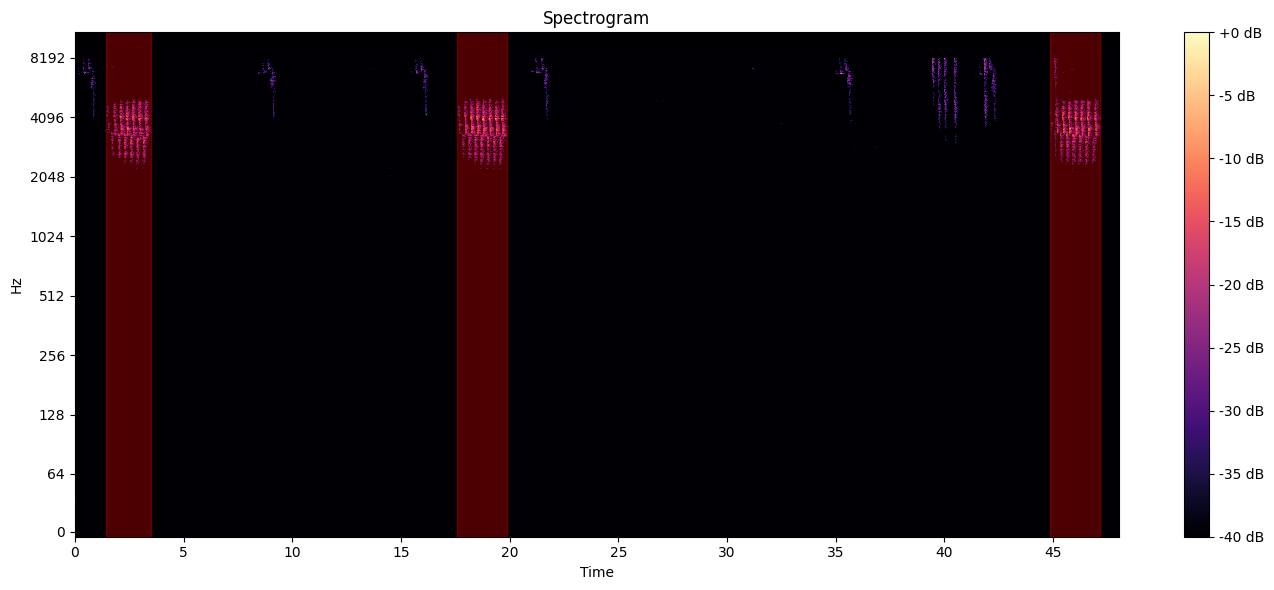

In [338]:
# Iterate here, play with these 4 numbers until the event detector is different. 

species_idx = 0
folder = raw_folders[species_idx]
species_label = folders[species_idx]
files = [f for f in os.listdir(folder) if f.endswith(('.mp3', '.MP3', '.wav', '.WAV'))]

# change the parameters for each bird, especially the bandpass filter limits
tf = 0.2    # threshold used for determining an event 
md = 1.0    # minimum duration of a detected event (all events less will be lost)
bpll = 2048 # lower limit of the bandpass filter (if filtering)
bpul = 8192 # upper limit of the bandpass filter (if filtering)

y,y_denoised,sr,timestamps = detected_times(os.path.join(raw_folders[0],files[2]),
                                threshold_factor=tf,min_duration=md,
                                apply_bandpass=True,bpll=bpll,bpul=bpul)
plot_spectrogram(y, sr, timestamps,threshold = -40)

In [314]:
# Apply to all files in the folder, make dataframe , save event detections
data = []

files = [f for f in os.listdir(folder) if f.endswith(['.mp3', '.MP3', '.wav', '.WAV'])]

for i,filename in enumerate(files):
    if filename.endswith(('.wav','.mp3')):
        #_,_,_,timestamps = detected_times(os.path.join(raw_folder,filename),threshold_factor=tf,min_duration=md)
        
        # Populate the data list with rows
        _,_,_,timestamps = detected_times(os.path.join(raw_folder,filename),
                                threshold_factor=tf,min_duration=md,
                                apply_bandpass=True,bpll=bpll,bpul=bpul)
        for start_time, end_time in timestamps:
            data.append([filename, start_time, end_time, species_label])
        # plot_spectrogram(y, sr, timestamps)
    
# Create a DataFrame from the data
df = pd.DataFrame(data, columns=['filename', 'start_time', 'end_time', 'species'])

# Save the DataFrame to a CSV file
df.to_csv(os.path.join(raw_folder,'event_detections.csv'), index=False)

TypeError: endswith first arg must be str or a tuple of str, not list

# Option 2: Find parameters for each file 

In [396]:
# First Initialize the lists necessary
species_idx = 5

folder = raw_folders[species_idx]
species_label = folders[species_idx]
files = [f for f in os.listdir(folder) if f.endswith(('.mp3', '.MP3', '.wav', '.WAV'))]

tf, md, bpll, bpul = [None]*len(files), [None]*len(files), [None]*len(files), [None]*len(files)
files

['20211115_034400_SS.wav',
 '20211115_181100_SS.wav',
 '20211115_031100_SS.wav',
 '20211115_041130_SS.wav',
 '20211115_044430_SS.wav']

In [404]:
# go through all file indexes, set parameters for each file
file_idx = 5 # start with 0 

folder = raw_folders[species_idx] 
species_label = folders[species_idx] 
files = [f for f in os.listdir(folder) if f.endswith(('.mp3', '.MP3', '.wav', '.WAV'))]

tf[file_idx] = 0.6 # threshold used for determining an event 
md[file_idx] = 0.3 # minimum duration of a detected event (all events less will be lost) 
apply_bandpass = True 
bpll[file_idx] = 1500 # lower limit of the bandpass filter (if filtering), must be >0 
bpul[file_idx] = 4000 # upper limit of the bandpass filter (if filtering)

y,y_denoised,sr,timestamps = detected_times(os.path.join(folder,files[file_idx]),
                    threshold_factor=tf[file_idx],min_duration=md[file_idx],
                    apply_bandpass=apply_bandpass,bpll=bpll[file_idx],bpul=bpul[file_idx]) 
plot_spectrogram(y, sr, timestamps,threshold = -40)


IndexError: list assignment index out of range

In [312]:
# Take these settings, and make the event detection csv files
data = []

for i,filename in enumerate(files):
    if filename.endswith(('.mp3', '.MP3', '.wav', '.WAV')):
        _,_,_,timestamps = detected_times(os.path.join(folder,filename),
                                threshold_factor=tf[i],min_duration=md[i],
                                apply_bandpass=True,bpll=bpll[i],bpul=bpul[i])
        for start_time, end_time in timestamps:
            data.append([filename, start_time, end_time, species_label])
        # plot_spectrogram(y, sr, timestamps)
    
# Create a DataFrame from the data
df = pd.DataFrame(data, columns=['filename', 'start_time', 'end_time', 'species'])

# Save the DataFrame to a CSV file
df.to_csv(os.path.join(folder,'event_detections.csv'), index=False)

20211115_171506_CCD.wav
20211115_171506_CCD.wav
20211115_171506_CCD.wav
20211115_171506_CCD.wav
20211115_171506_CCD.wav
20211115_171506_CCD.wav
20211115_171506_CCD.wav
20211115_171506_CCD.wav
20211115_171506_CCD.wav
20211115_171506_CCD.wav
20220301_195300_CCD.WAV
20220302_031100_CCD.WAV
20220302_031100_CCD.WAV
20220302_031100_CCD.WAV
20220302_031100_CCD.WAV
20220302_031100_CCD.WAV
20220302_031100_CCD.WAV
20220302_031100_CCD.WAV
20220302_031100_CCD.WAV
20220302_031100_CCD.WAV
20220302_031100_CCD.WAV
20220302_030530_CCD_L.WAV
20220302_030530_CCD_L.WAV
20220302_030530_CCD_L.WAV
20220302_030530_CCD_L.WAV
20220302_030530_CCD_L.WAV
20220301_194730_CCD.WAV
20220301_194730_CCD.WAV
20220301_194730_CCD.WAV
20220301_194730_CCD.WAV
20220301_194730_CCD.WAV
20220301_194730_CCD.WAV
20220301_194730_CCD.WAV
20220301_194730_CCD.WAV
20220301_194730_CCD.WAV
20220301_194730_CCD.WAV
20220301_194730_CCD.WAV
20220301_194730_CCD.WAV
20220301_194730_CCD.WAV
20220301_194730_CCD.WAV
20220301_194730_CCD.WAV
202203

[0.25, 2.5, 0.6, 1.5, 0.27, 0.8, 0.6]

In [ ]:
## here's some functions to help look at/ listen to your data, to help with debugging 
# play_audio_events(y_denoised, sr, timestamps)
# play_audio_events(y, sr, timestamps)
# plot_spectrogram(y, sr, timestamps,threshold = -40)
# plot_spectrogram(y_denoised, sr, timestamps,threshold = -40)